In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
uploaded = files.upload()
for filename in uploaded.keys():
    data = pd.read_excel(filename)

Saving TLKM_FINAL.xlsx to TLKM_FINAL.xlsx


In [3]:
data['pct_change'] = data['Close'].pct_change() * 100
data.dropna(inplace=True)

Threshold = 1% Movement Distribution:
movement_1
 1    289
 0    214
-1    277
Name: count, dtype: int64

Threshold = 2% Movement Distribution:
movement_2
 1    211
 0    388
-1    181
Name: count, dtype: int64

Threshold = 3% Movement Distribution:
movement_3
 1    134
 0    533
-1    113
Name: count, dtype: int64



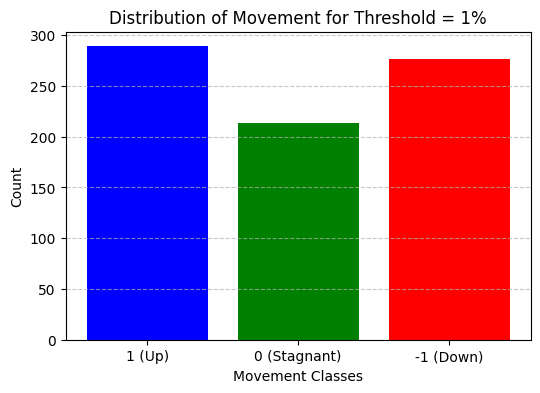

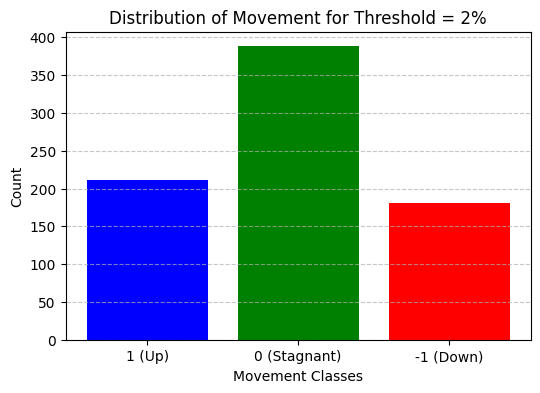

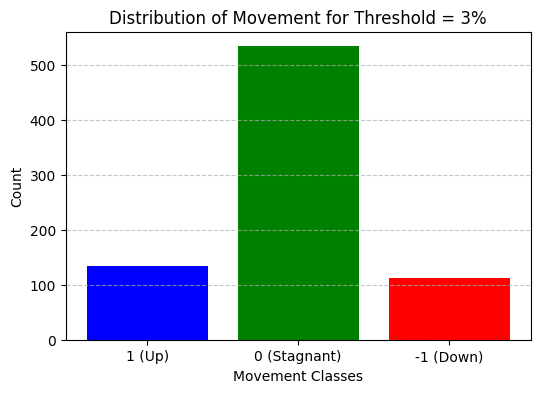

In [4]:
thresholds = [1, 2, 3]
movement_distributions = {}

for threshold in thresholds:
    data[f'movement_{threshold}'] = data['pct_change'].apply(
        lambda x: 1 if x > threshold else (-1 if x < -threshold else 0)
    )
    movement_distributions[threshold] = data[f'movement_{threshold}'].value_counts().reindex([1, 0, -1], fill_value=0)

    print(f"Threshold = {threshold}% Movement Distribution:")
    print(movement_distributions[threshold])
    print()

colors = ['blue', 'green', 'red']
for threshold in thresholds:
    movement_counts = movement_distributions[threshold]
    x_labels = ['1 (Up)', '0 (Stagnant)', '-1 (Down)']

    plt.figure(figsize=(6, 4))
    plt.bar(x_labels, movement_counts.values, color=colors)
    plt.title(f'Distribution of Movement for Threshold = {threshold}%')
    plt.xlabel('Movement Classes')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Split Data

In [5]:
best_threshold = 2

In [6]:
X = data[['pct_change', 'ROA', 'P/B Value']].values
y = data[f'movement_{best_threshold}'].values

split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

y_one_hot_train = to_categorical(y_train + 1, num_classes=3)
y_one_hot_test = to_categorical(y_test + 1, num_classes=3)

Training Data Distribution:
-1: 150
0: 304
1: 170

Testing Data Distribution:
-1: 31
0: 84
1: 41


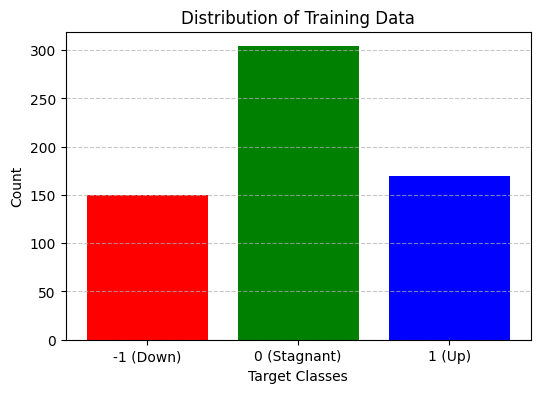

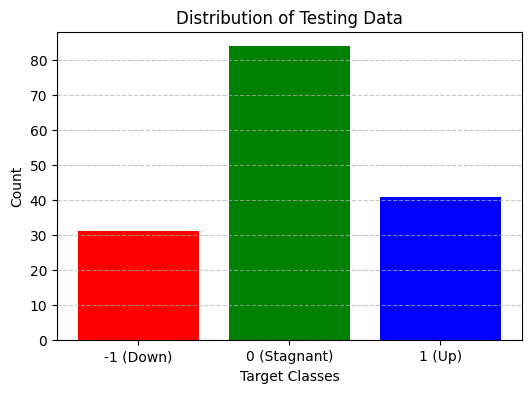

In [7]:
train_distribution = np.unique(y_train, return_counts=True)
test_distribution = np.unique(y_test, return_counts=True)

train_dist_dict = dict(zip(train_distribution[0], train_distribution[1]))
test_dist_dict = dict(zip(test_distribution[0], test_distribution[1]))

classes = [-1, 0, 1]
train_counts = [train_dist_dict.get(cls, 0) for cls in classes]
test_counts = [test_dist_dict.get(cls, 0) for cls in classes]

print("Training Data Distribution:")
for cls, count in zip(classes, train_counts):
    print(f"{cls}: {count}")

print("\nTesting Data Distribution:")
for cls, count in zip(classes, test_counts):
    print(f"{cls}: {count}")

plt.figure(figsize=(6, 4))
plt.bar(['-1 (Down)', '0 (Stagnant)', '1 (Up)'], train_counts, color=['red', 'green', 'blue'])
plt.title('Distribution of Training Data')
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['-1 (Down)', '0 (Stagnant)', '1 (Up)'], test_counts, color=['red', 'green', 'blue'])
plt.title('Distribution of Testing Data')
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Normalisasi Data

In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Bangun Model

In [9]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Kompilasi Model

In [10]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Latih Model

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_one_hot_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_one_hot_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4054 - loss: 1.1263 - val_accuracy: 0.5385 - val_loss: 0.9611
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4900 - loss: 0.9253 - val_accuracy: 0.5385 - val_loss: 0.8225
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5260 - loss: 0.8065 - val_accuracy: 0.5385 - val_loss: 0.7441
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4840 - loss: 0.7513 - val_accuracy: 0.5385 - val_loss: 0.6943
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4823 - loss: 0.7044 - val_accuracy: 0.5385 - val_loss: 0.6617
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4894 - loss: 0.6764 - val_accuracy: 0.5385 - val_loss: 0.6402
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4824 - loss: 0.6542 - val_accuracy: 0.5385 - val_loss: 0.6262
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4890 - loss: 0.6428 - val_accuracy: 0.5385 - val_loss:

## Evaluasi Model

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


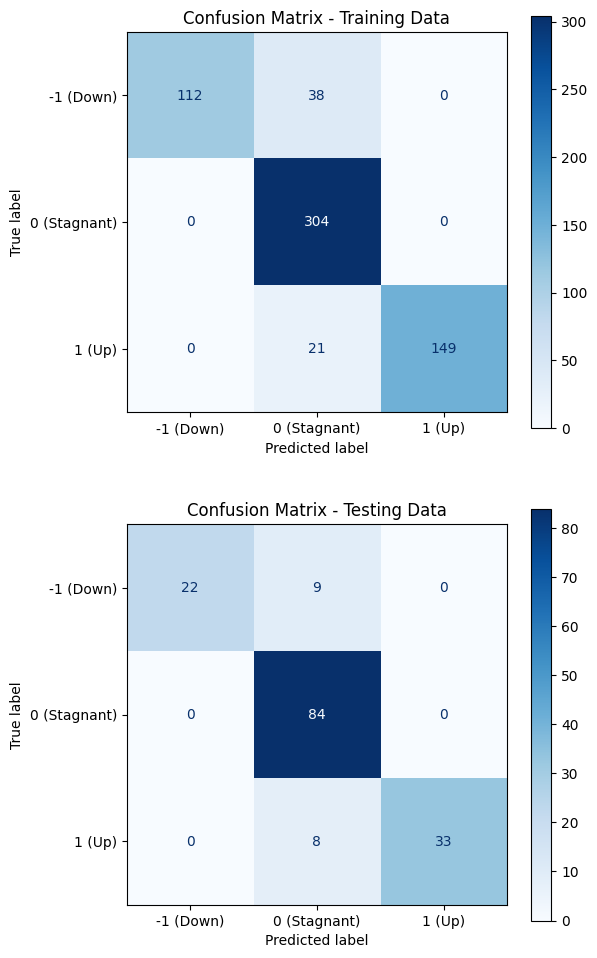

In [12]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_prob, axis=1) - 1
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1) - 1
conf_matrix_train = confusion_matrix(y_train, y_train_pred, labels=[-1, 0, 1])
conf_matrix_test = confusion_matrix(y_test, y_test_pred, labels=[-1, 0, 1])

fig, axes = plt.subplots(2, 1, figsize=(6, 10))

disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['-1 (Down)', '0 (Stagnant)', '1 (Up)'])
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=True)
axes[0].set_title("Confusion Matrix - Training Data")
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=['-1 (Down)', '0 (Stagnant)', '1 (Up)'])
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=True)
axes[1].set_title("Confusion Matrix - Testing Data")

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1_score = f1_score(y_train, y_train_pred, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')

train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')

train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

evaluation_results = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Training': [train_accuracy, train_f1_score, train_precision, train_recall],
    'Testing': [test_accuracy, test_f1_score, test_precision, test_recall]
})

print(evaluation_results.to_string(index=False))

   Metric  Training  Testing
 Accuracy  0.905449 0.891026
 F1 Score  0.904107 0.888362
Precision  0.920817 0.909368
   Recall  0.905449 0.891026
